# Chemical disaster in Wilmington, Delaware 1977
Exothermic chemical reaction system in a CSTR model


## Description


In 1977, a new nitrous oxide ($N_2O$) plant in Wilmington, Delaware was destroyed by a horrific explosion. Shortly after the disaster, a local news paper published an atricle and it was mentioned that the explosion could have been caused by gaseous ammonium nitrate ($NH_4NO_3$, the key compound in nitrous oxide production). In 1999, H. Fogler published information on the plant's operations leading up to the catastrophe, urging young engineers to find the cause of the explosion.

Thus, the data and subsequently the problem formulation below is taken from the 3rd edition of H. Fogler's 1999 book *Elements of Chemical Reaction Engineering*. 

## Reaction system & constants


Nitous oxide is commercially produced according to this reaction:

$NH_4NO_3  \to\ N_2O + 2H_2O $ {eq.1}

which is simplified to:

$ A  \to\ B + 2C $ {eq.2}


| Variable  | Symbol | value | UoM |
|-------------------------|---------------------------|----------------------|-------------------|
| $NH_4NO_3$ feed inclusion level |   -  |  83%  |  (wt%)   |
| $H_2O$ feed concentration              |   -  |17% | (wt%) |
| Feed temperature | $T_0$ | 200 | F |
| Feed flow rate | $F_0$ | 310 | $\frac{lb}{h} $|
| $NH_4NO_3$ in the reactor | $M_A$ | 500 | $lb$ |
| Fractional conversion of $NH_4NO_3$| X       | 99.99 | $%$ |
| Heat of reaction at 500 F | ${H_{rxn}(500)}$   | -336 | $Btu/lb$ |
| $H_2O_{(l)}$ enthalpy at 200 F | $H_{C,T=200}$ | 168 |$Btu/lb$ |
| $H_2O_{(g)}$ enthalpy at 500 F | $H_{C,T=500}$ | 1202 |$Btu/lb$ |
| Heat capacity of $NH_4NO_3$ | $Cp_A$ | 0.38 |$Btu/lb.F$ |
| Heat capacity of $H_20$ | $Cp_C$ | 0.47 |$Btu/lb.F$ |
| Reaction rate constant at 510 F | $k(510)$ | 0.307 | $h^{-1}$|
| Reaction rate constant at 560 F | $k(560)$ | 2.912 | $h^{-1}$|


It is believed that pressure fluctuations were being observed in the system and the feed to the reactor was subsequently shutoff. The explosion followed soon thereafter. 










In [2]:
#%% Imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import newton_krylov as fsolve

#%% Reactions & stoichiometry

# NH4NO3 -> N2O+2H2O 
# A -> B + 2C
stoic_table=np.array([-1,1,2])
Molar_mass=np.array([80,44,18])

#%% System Constants

F_0=310 #lb/h
T0=200 #F
Amonium_feed=0.83
theta=np.array([1,0/Amonium_feed,(1-Amonium_feed)/Amonium_feed])
M=500 #lb
X=0.9999
dHrxn_0=-336 #Btu/lb @959.67 R @500 F

H_H2O_l=168 #Btu/lb
H_H2O_g=1202 #Btu/lb
Cp_NH4NO3=0.38 #Btu/lb
Cp_H2O=0.47 #Btu/lb

rate_constants=pd.DataFrame({
        'Temperature':[969.67, 1019.67], #Temperature in R
        'rate':[0.307, 2.912]      #rate constants in /h
        })


## Model Development

To begin with, it is necessary to calculate some missing information about the reaction system. The activation energy of the reaction system and the average heat capacity of $N_2O$ are of paramount importance. 
### Reaction Activation Energy calculation


$k(T)=k(T_0)exp[\frac{E_a}{R}(\frac{T+T_0}{TT_0})]$    {eq.3}

where $k(T)$ is the rate constant at temperature $T$, $E_a$ is the reactions activation energy and $R$ is the universal gas constant. 

Rearranging eq.3 gives:

$E_a = ln[\frac{k(T)}{k(T_0)}][\frac{RTT_0}{T-T_0}]$   {eq.4}


In [7]:
#find the activation energy of the reaction
R=1.986 #Btu/lbmol/R
E=(math.log(rate_constants['rate'][0]/rate_constants['rate'][1])*
(R*rate_constants['Temperature'][0]*rate_constants['Temperature'][1]/
(rate_constants['Temperature'][1]-rate_constants['Temperature'][0]))) #Btu/lbmol

print('The activation energy is:',round(E),'Btu/lbmol')

The activation energy is: -88354.0 Btu/lbmol


### $N_2O$ heat capacity calculation

Having all heat capacities except one allows us to solve for the unknown heat capacity using the heat of reaction equation below. 

$\Delta H_{rxn}(T)=\Delta H^0_{rxn}(T_0)+ \Delta Cp(T-T_0)$       {eq.5}

Where $\Delta H_{rxn}(T)$ is the heat of reaction at temperature $T$, $Cp$ is the heat capacity and, 

$ \Delta H^0_{rxn}(T_0) = \sum\limits_{i=1} \upsilon_i H^0_{f,i} $ {eq.6}

and $\upsilon_i$ is the stoichiometric coefficient of reaction species $i$, $H^0_{f,i}$ is the heat of formation of reaction species $i$ and:

$\Delta Cp =\sum\limits_{i=1} \upsilon_i Cp_i$ {eq.7}



In [9]:
#use standard heats of formation to find CP_N2O
dHF_0=np.array([-339.4,81.55,-241.8])*430.6#Btu/lbmol
dHF_0=(dHF_0/Molar_mass)#Btu/lb

#standard heat of reaction at T=77 F:
dHrxn_T25=dHF_0@stoic_table

Cp_N2O=(dHrxn_0-dHrxn_T25)/(500-77)+(Cp_NH4NO3)-(2*Cp_H2O) #Btu/lb

print('Cp_N2O = ',round(Cp_N2O),'Btu/lb')

Cp_N2O =  20.0 Btu/lb


## Reaction system Mass and Energy balance

The nitrous oxide plant used a CSTR reactor. The design equation (mass balance) of a CSTR is shown in eq.8 below.

$F_{A,0}X=-r_AV$     {eq.8}

Where $F_{A,0}$ is the inlet flow rate of species A, $X$ is the fractional conversion, $-r_A$ is the rate of consumption of species A and $V$ is the system Volume. 


Eq.1 follows first-order reaction kinetics.

$-r_AV=kC_AV=kM_A$   {eq.9}

Here, $C_A$ is the concentration of species A in the system and M is the mass/moles of species A.


From the mass balance in eq. 8 and kinetics in eq.9 we can solve for the fractional conversion of A with eq. 10 below. 

$X=\frac{k}{1+k}$    {eq.10}

*NB: eq.10 shows that the $\tau=1$ for the system as the first principles derivation of fractional conversion from a first order reaction in a CSTR yields $X=\frac{\tau k}{1+\tau k}$*

Where:
$\tau= \frac{V_{sys}}{V_0}$ {eq.11}

$\tau$ is also known as the space time of the reactor. In eq.11 $V_{sys}$ is the system volume and  $V_0$ is the total feed volumetric flow rate. 


The energy balance over the system gave eq.11 and eq.12 below which can be rearranged to Temperature as a function of conversion and the converse. 

$ T=\frac{\Delta H_rxn(T_R)X+\sum \Theta_iCp_iT_0-\Theta_C[H_{C,T=500}-H_{C,T=200}]-\Delta CpT_R*X}{\sum \Theta_iCp_i-\Delta CpX}$     {eq. 12}

where $T_R$ is the reference temperature, $T_0$ is the feed inlet temperature, $\Theta_i$ is the ratio of species i to species A in the reactor feed. e.g.  $\Theta_i=\frac{F_{i,0}}{F_{A,0}}$, $H_{C,T=200}$ is the enthalpy of $H_2O_{(l)}$ at 200 F while $H_{C,T=500}$ is it's enthalpy at 500 F.


$ X_{EB}= \frac{\sum \Theta_i Cp_i (T-T_0)+ \Theta_C[H_{C,T=500}-H_{C,T=200}]}{\Delta H^0_rxn(T_r)+\Delta Cp(T-T_R)}$    {eq. 13}

Here $X_{EB}$ is the fractional conversion calculated from an energy balance. 


The Temperature of the system just before the feed was shutoff can be calculated using eq. 12.


In [10]:
#%% Reaction system

#Find the temperature
dCp=stoic_table@np.array([Cp_NH4NO3,Cp_N2O,Cp_H2O])
Cp=np.array([Cp_NH4NO3,Cp_N2O,Cp_H2O])
T=(-dHrxn_0*X-theta[2]*(H_H2O_g-H_H2O_l)+theta@Cp*T0+dCp*X*500)/(theta@Cp+dCp*X)
k=rate_constants['rate'][0]*math.exp((E/R)*(1/(T+460)-1/rate_constants['Temperature'][0]))
mass=(F_0*X*Amonium_feed)/(k*M) #mass per ft^3 of the system

tau=1 #recal from X_MB derivation

print('Reactor temperature before feed shutoff = ',round(T),'F')

Reactor temperature before feed shutoff =  499.0 F


## Reaction system analysis

We can evaluate the heat generation $G(T)$ and heat removal $R(T)$ curves of this reaction system using the equations below.

$G(T)=(-\Delta H^0_{rxn})X_{MB} $         {eq.14}


$R(T)=\sum \Theta_iCp_i(1-\kappa)(T-T_c)$     {eq.15}  

where

$\kappa = \frac{UA}{Cp_0F_{A0}}$ and $T_c = \frac{\kappa Ta+T_0}{1+\kappa}$ {eq.16 & 17}


Here it is assumed that the system is adiabatic and thus $\kappa = 0$. This results in $T_c = T_0$.


Eq. 14 & 15 follow from the system's energy balance where the shaft work is assumed to be negligible and setting $\Delta Cp = 0$



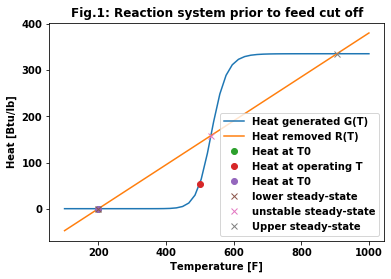

In [26]:
#define the reaction system function which returns conversion and heat generated/removed

def f(T):
    k=rate_constants['rate'][0]*math.exp((E/R)*(1/(T+460)-1/rate_constants['Temperature'][0]))
    X_MB=k*tau/(1+k*tau)
    X_EB=(theta@Cp*(T-T0)+theta[2]*(H_H2O_g-H_H2O_l))/-(dHrxn_0+dCp*(T-500))
    G_T=-(dHrxn_0)*X_MB
    R_T=Cp@theta*(T-T0)
    
    return [X_MB,G_T,R_T]

H=lambda T:f(T)[1]-f(T)[2]

T_i = np.linspace(T0-100,1000)


fig_1 = plt.figure()
chart=plt.subplot(111)
chart.plot(T_i,np.array(list(map(f,T_i)))[:,1],label='Heat generated G(T)')
chart.plot(T_i,np.array(list(map(f,T_i)))[:,2],label='Heat removed R(T)')

chart.plot(T0,f(T0)[2],'o',label='Heat at T0')
chart.plot(T,f(T)[1],'o',label='Heat at operating T')
chart.plot(T0,f(T0)[2],'o',label='Heat at T0')
chart.plot(T0,f(T0)[2],'x',label='lower steady-state')
chart.plot(532.77,f(532.77)[2],'x',label='unstable steady-state')
chart.plot(fsolve(H,1000),f(fsolve(H,1000))[2],'x',label='Upper steady-state')

chart.set_xlabel('Temperature [F]')
chart.set_ylabel('Heat [Btu/lb]')
plt.title('Fig.1: Reaction system prior to feed cut off')
chart.legend()
plt.show()


The intersections of $G(T)$ and $R(T)$ show the steady-state operating temperatures for the given feed temperature ($T_0$) and the current space time ($\tau$). 

Fig.1 shows that just before the reactor feed was cut off the reaction system was operating above the lower steady state but below the unstable steady state. In this region, the reaction is stable as the heat removed is greater than the heat generated, thus forcing the system temperature towards the lower steady state operating temperature. At the unstable steadystate operating temperature, a single pulse increase in Temperature would result in the heat generated being greater than the heat removed, subsequently forcing the reaction system towards the higher steady-state operating temperature. The unstable steady state temperature is also known as the reaction ignition temperature. 

**NB:** Once the operating temperature of the CSTR reaches the unsteady state temperature a small pertubation of temperature can cause the reaction to run away. Resulting, for this case, in fatal disaster. 

## What happened to the reaction system after the reactor feed was shut off?

Let us begin by considering the case where the reactor feed is gradually reduced. the reduction in feed flow increases the space-time of the reaction system (recall eq. 11). The effect of the space-time on the reaction is illustrated in the figure below. 

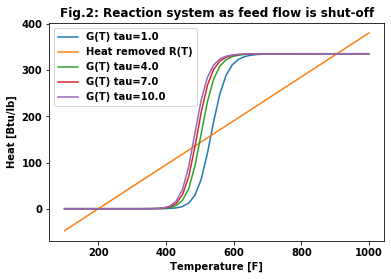

In [41]:
tau_i=list(np.linspace(1,10,4))
G_tau=[]
for item in tau_i:
    tau=item
    G_tau.append(np.array(list(map(f,T_i)))[:,1])


fig2=plt.figure()
chart2=plt.subplot(111)
chart2.plot(T_i,G_tau[0],label='G(T) tau='+str(tau_i[0]))
chart2.plot(T_i,np.array(list(map(f,T_i)))[:,2],label='Heat removed R(T)')
chart2.plot(T_i,G_tau[1],label='G(T) tau='+str(tau_i[1]))
chart2.plot(T_i,G_tau[2],label='G(T) tau='+str(tau_i[2]))
chart2.plot(T_i,G_tau[3],label='G(T) tau='+str(tau_i[3]))
chart2.set_xlabel('Temperature [F]')
chart2.set_ylabel('Heat [Btu/lb]')
plt.title('Fig.2: Reaction system as feed flow is shut-off')

chart2.legend()
plt.show()


From fig.2 it is evident that as the space-time of the reaction increases - the reactions ignition temperature decreases. However, it does not decrease indefinitely - it approaches a lower limit as $\lim\limits_{\tau\to\infty}X_{MB}=1$.

The decrease in ignition temperature is significant enough to dip below the operating temperature and produce a runaway reaction which subsequently can cause an explosion.

Hence, it can be concluded that the act of shutting off the reactor feed due to the perceived presure pertubations increased the reactor space time which subsequently decreased the reaction's ignition temperature leaving the reaction unstable and dangerous. 


